#### **COVID-19 VACCINATION ANALYSIS AND PREDICTION**

**Project goal:**
- Clean up the data to be ready for further analysis.
- Use exploratory data analysis to understand the characteristics of the data, review the current COVID-19 vaccination progress around the world.
- Predict countrywise estimated days to vaccinate the target % population (to achieve **“collective immunity” threshold** using historical data from the source. Although we can do it for multiple countries, for simplicity and ease of understanding we have restricted the target country to the United States.


**Data source:**
- Our data is taken from **Our World In Data**'s website as below link:
https://ourworldindata.org/covid-vaccinations
- Github repository: https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations

**In this notebook we have accomplished the process of dealing with the missing values followed by exploratory data analysis involving vaccine types and their usage.**

**Data definition:**

**1. Country_Vaccinations File**

**country** - this is the country for which the vaccination information 
is provided;

**iso_code** - ISO code for the country;

**date** - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total

**total_vaccinations** - this is the absolute number of total immunizations in the country;

**people_vaccinated** - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;

**people_fully_vaccinated** - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;

**daily_vaccinations_raw** - for a certain data entry, the number of vaccination for that date/country;

**daily_vaccinations** - for a certain data entry, the number of vaccination for that date/country;

**total_vaccinations_per_hundred** - ratio (in percent) between vaccination number and total population up to the date in the country;

**people_vaccinated_per_hundred** - ratio (in percent) between population immunized and total population up to the date in the country;

**people_fully_vaccinated_per_hundred** - ratio (in percent) between population fully immunized and total population up to the date in the country;

**daily_vaccinations_per_million** - ratio (in ppm) between vaccination number and total population for the current date in the country;

**vaccines** - Name of the vaccine

**source_name** - source of the information (national authority, international organization, local organization etc.);

**source_website** - website of the source of information;

**2. Country_List File**

**country_name** - Name of the country;

**iso_code** - ISO code of the country;

**continent** - Name of the continent in which the country exists 

## 1. Import libraries and load datasets

### Import libraries

In [1]:
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
warnings.filterwarnings('ignore')
!pip install fuzzywuzzy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
!pip install recordlinkage
import recordlinkage 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 952kB 12.6MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 


### Load datasets

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/Shared drives/IS833 Covid vaccination prediction/'

Mounted at /content/gdrive


In [3]:
# kaggle dataset with vaccination data by country
kaggledata = pd.read_csv('/content/gdrive/Shareddrives/IS833 Covid vaccination prediction/covid_vaccination_data/country_vaccinations.csv')

In [4]:
# country list by continent, to merge with main dataset for analysis by continent
country = pd.read_excel('/content/gdrive/Shareddrives/IS833 Covid vaccination prediction/covid_vaccination_data/Country_list.xlsx')

In [5]:
kaggledata.head(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


In [6]:
country.head()

,Country name,iso_code,Continent
0,"Afghanistan, Islamic Republic of",AFG,Asia
1,"Albania, Republic of",ALB,Europe
2,Antarctica (the territory South of 60 deg S),ATA,Antarctica
3,"Algeria, People's Democratic Republic of",DZA,Africa
4,American Samoa,ASM,Oceania


In [7]:
# Check whether all the records are successfully imported
kaggledata.shape 

(13600, 15)

In [8]:
# Check for missing records
kaggledata.count()

country                                13600
iso_code                               13600
date                                   13600
total_vaccinations                      8096
people_vaccinated                       7387
people_fully_vaccinated                 5377
daily_vaccinations_raw                  6781
daily_vaccinations                     13388
total_vaccinations_per_hundred          8096
people_vaccinated_per_hundred           7387
people_fully_vaccinated_per_hundred     5377
daily_vaccinations_per_million         13388
vaccines                               13600
source_name                            13600
source_website                         13600
dtype: int64

There are NA values in the dataset. As total_vaccinations and people_vaccinated are our key focus, we decide to remove all rows in which total_vaccinations is Null

In [9]:
# Drop rows in which total_vaccinations is missing and total_vaccinations is 0
kaggledata = kaggledata[kaggledata['total_vaccinations'].notna()]
kaggledata = kaggledata[kaggledata['total_vaccinations'] != 0]

### Merge the 2 dataframes

In [10]:
# merge 2 df so that we can do further analysis by continent
kaggledata = pd.merge(kaggledata,country)
kaggledata.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country name,Continent
0,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia
1,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,2862.0,0.14,0.14,NaN,74.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia
2,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,3000.0,0.31,0.31,NaN,77.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia
3,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,8000.0,0.62,0.62,NaN,206.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia
4,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,"Pfizer/BioNTech, Sinovac",Ministry of Health,https://twitter.com/gmanastirliu/status/138569...,"Albania, Republic of",Europe


### **Clean the data and take care of the null values**

In [11]:
#check count of null values
kaggledata.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                       817
people_fully_vaccinated                2663
daily_vaccinations_raw                 1257
daily_vaccinations                       89
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred           817
people_fully_vaccinated_per_hundred    2663
daily_vaccinations_per_million           89
vaccines                                  0
source_name                               0
source_website                            0
Country name                              0
Continent                                 0
dtype: int64

Check how the features are correlated with each other so that we can establish our null hypotheses

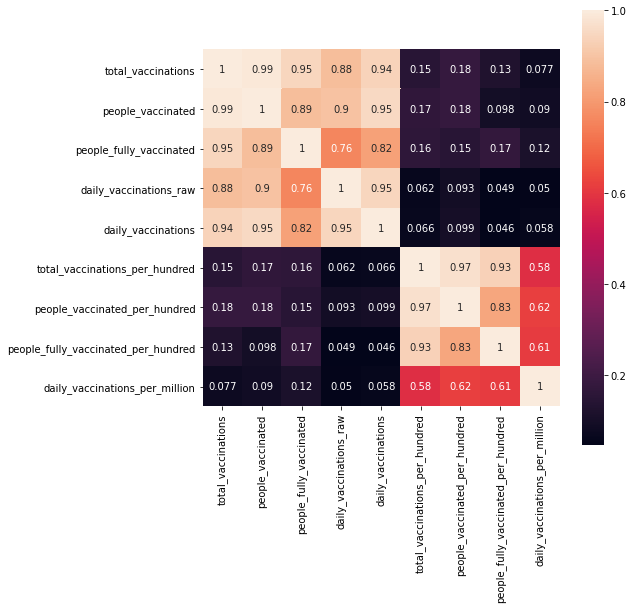

In [12]:
plt.subplots(figsize=(8, 8))
sns.heatmap(kaggledata.corr(), annot=True, square=True)
plt.show()

For some countries, there is only data about total vaccinations but missing number of vaccinated people. For our analysis, we will estimate people_vaccinated based on the average ratio of remaining countries

In [13]:
# Calculate total population of each country based on Total vaccinations and % vaccinated rate
kaggledata['Population'] = round(kaggledata['total_vaccinations'] / kaggledata ['total_vaccinations_per_hundred'] *100)
kaggledata.head(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country name,Continent,Population
0,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,41000000.0
1,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,2862.0,0.14,0.14,NaN,74.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38571429.0
2,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,3000.0,0.31,0.31,NaN,77.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677.0
3,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,8000.0,0.62,0.62,NaN,206.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677.0
4,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,"Pfizer/BioNTech, Sinovac",Ministry of Health,https://twitter.com/gmanastirliu/status/138569...,"Albania, Republic of",Europe,inf


In [14]:
# select the latest entry for each country to obtain the latest total vaccinations and people_vaccinated as of today
kaggledata_latest = kaggledata.iloc[kaggledata.groupby('country')['total_vaccinations'].agg(pd.Series.idxmax)]
kaggledata_latest.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country name,Continent,Population
3,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,8000.0,0.62,0.62,NaN,206.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677.0
55,Albania,ALB,2021-04-23,391351.0,NaN,NaN,8353.0,10961.0,13.60,NaN,NaN,3809.0,"Pfizer/BioNTech, Sinovac",Ministry of Health,https://twitter.com/gmanastirliu/status/138569...,"Albania, Republic of",Europe,2877581.0
57,Algeria,DZA,2021-02-19,75000.0,NaN,NaN,NaN,3748.0,0.17,NaN,NaN,85.0,Sputnik V,Ministry of Health,https://www.echoroukonline.com/%d9%84%d9%82%d8...,"Algeria, People's Democratic Republic of",Africa,44117647.0
73,Andorra,AND,2021-04-19,26414.0,21733.0,4681.0,NaN,1050.0,34.19,28.13,6.06,13590.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of Andorra,https://www.govern.ad/covid19_newsletter/,"Andorra, Principality of",Europe,77257.0
80,Angola,AGO,2021-04-19,395447.0,395447.0,NaN,NaN,18751.0,1.20,1.20,NaN,571.0,Oxford/AstraZeneca,Ministry of Health,https://www.angop.ao/en/noticias/saude/covid-1...,"Angola, Republic of",Africa,32953917.0


In [15]:
# calculate the average rate of people_vaccinated / total_vaccination as of today for countries with non Null values
rate = kaggledata_latest.loc[kaggledata_latest['people_vaccinated'].notnull(),'total_vaccinations'].sum()/kaggledata_latest.loc[kaggledata_latest['people_vaccinated'].notnull(),'people_vaccinated'].sum()
rate

1.4059474784100388

The rate is 1.41 as there are people who already got 2 doses, making total_vaccination bigger than people_vaccinated

In [16]:
# we estimate people_vaccinated in missing rows by dividing total vaccinations by 1.36 (the conversion rate calculated in above section).
kaggledata.people_vaccinated=kaggledata.people_vaccinated.fillna(kaggledata['total_vaccinations']/rate)
# calculate % people vaccinated based on the above estimated people_vaccinated and population
kaggledata.people_vaccinated_per_hundred=kaggledata.people_vaccinated_per_hundred.fillna(kaggledata['people_vaccinated']/kaggledata['Population']*100)

In [17]:
#check the count of null values
kaggledata.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                2663
daily_vaccinations_raw                 1257
daily_vaccinations                       89
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred    2663
daily_vaccinations_per_million           89
vaccines                                  0
source_name                               0
source_website                            0
Country name                              0
Continent                                 0
Population                                0
dtype: int64

Null hypothesis: people_fully_vaccinated and people_fully_vaccinated_per_hundred are strongly correlated with total_vaccinations and total_vaccinations_per_hundred respectively.

In [18]:
scipy.stats.mannwhitneyu(kaggledata.people_fully_vaccinated, kaggledata.total_vaccinations, alternative='two-sided')

MannwhitneyuResult(statistic=39522357.0, pvalue=1.9708254656805788e-84)

In [19]:
scipy.stats.mannwhitneyu(kaggledata.people_fully_vaccinated_per_hundred, kaggledata.total_vaccinations_per_hundred, alternative='two-sided')

MannwhitneyuResult(statistic=37305630.5, pvalue=5.215109601789528e-34)

p-value is much less than 0.05, which means we will reject our hypothesis.

In [20]:
#Since null hypothesis is rejected fill the null values with 0
kaggledata.people_fully_vaccinated = kaggledata.people_fully_vaccinated.fillna(0)
kaggledata.people_fully_vaccinated_per_hundred = kaggledata.people_fully_vaccinated_per_hundred.fillna(0)

In [21]:
#check the count of null values
kaggledata.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                   0
daily_vaccinations_raw                 1257
daily_vaccinations                       89
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred       0
daily_vaccinations_per_million           89
vaccines                                  0
source_name                               0
source_website                            0
Country name                              0
Continent                                 0
Population                                0
dtype: int64

Null Hypothesis: daily_vaccinations and daily_vaccinations_per_million strongly correlates with total_vaccinations and people_fully_vaccinated_per_hundred respectively

In [22]:
scipy.stats.mannwhitneyu(kaggledata.daily_vaccinations, kaggledata.total_vaccinations, alternative='two-sided')

MannwhitneyuResult(statistic=11401788.5, pvalue=0.0)

In [23]:
scipy.stats.mannwhitneyu(kaggledata.daily_vaccinations_per_million, kaggledata.people_fully_vaccinated_per_hundred, alternative='two-sided')

MannwhitneyuResult(statistic=66989510.0, pvalue=0.0)

In [24]:
#Since p-value is 0, fill the missing null records with 0
kaggledata.daily_vaccinations = kaggledata.daily_vaccinations.fillna(0)
kaggledata.daily_vaccinations_per_million = kaggledata.daily_vaccinations_per_million.fillna(0)

Null hypothesis: daily_vaccinations_raw is strongly correlated with daily_vaccinations

In [25]:
scipy.stats.mannwhitneyu(kaggledata.daily_vaccinations_raw, kaggledata.daily_vaccinations_per_million, alternative='two-sided')

MannwhitneyuResult(statistic=55871088.0, pvalue=0.0)

In [26]:
#Since p-value is 0, fill the missing null records with 0
kaggledata.daily_vaccinations_raw = kaggledata.daily_vaccinations_raw.fillna(0)

In [27]:
#check the count of null values
kaggledata.isna().sum()

country                                0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
Country name                           0
Continent                              0
Population                             0
dtype: int64

**Everything has worked fine since there are no null records**

## 2. Vaccine type analysis

### Extract list of vaccines used by each country

In [28]:
# Split vaccine column to obtain separated vaccines used by each country
vaccines = kaggledata['vaccines'].str.split(',', expand=True)
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8200 entries, 0 to 8199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       8200 non-null   object
 1   1       6623 non-null   object
 2   2       3692 non-null   object
 3   3       986 non-null    object
 4   4       330 non-null    object
dtypes: object(5)
memory usage: 384.4+ KB


In [29]:
# add Country column to df vaccines
vaccines['Country'] = kaggledata['country']
vaccines['Continent'] = kaggledata['Continent']
vaccines.head()

,0,1,2,3,4,Country,Continent
0,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
1,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
2,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
3,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
4,Pfizer/BioNTech,Sinovac,None,None,None,Albania,Europe


In [30]:
# rename columns name of vaccines
vaccines.columns=['Vaccine_1', 'Vaccine_2', 'Vaccine_3', 'Vaccine_4', 'Vaccine_5', 'Country', 'Continent']
vaccines.head()

,Vaccine_1,Vaccine_2,Vaccine_3,Vaccine_4,Vaccine_5,Country,Continent
0,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
1,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
2,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
3,Oxford/AstraZeneca,None,None,None,None,Afghanistan,Asia
4,Pfizer/BioNTech,Sinovac,None,None,None,Albania,Europe


In [31]:
# Extract list of Vaccine_1 for each country and remove duplicates
vaccine1 = vaccines[['Vaccine_1','Country','Continent']]
vaccine1_unique = vaccine1.drop_duplicates()
vaccine1_unique.head()

,Vaccine_1,Country,Continent
0,Oxford/AstraZeneca,Afghanistan,Asia
4,Pfizer/BioNTech,Albania,Europe
56,Sputnik V,Algeria,Africa
58,Oxford/AstraZeneca,Andorra,Europe
74,Oxford/AstraZeneca,Angola,Africa


In [32]:
# Extract list of Vaccine_2 for each country and remove NA/ duplicates
vaccine2 = vaccines[['Vaccine_2','Country','Continent']]
vaccine2_unique = vaccine2.dropna().drop_duplicates()
vaccine2_unique.head()

,Vaccine_2,Country,Continent
4,Sinovac,Albania,Europe
58,Pfizer/BioNTech,Andorra,Europe
97,Sinopharm/Beijing,Argentina,South America
210,Pfizer/BioNTech,Australia,Oceania
272,Oxford/AstraZeneca,Austria,Europe


In [33]:
# Extract list of Vaccine_3 for each country and remove NA/ duplicates
vaccine3 = vaccines[['Vaccine_3','Country','Continent']]
vaccine3_unique = vaccine3.dropna().drop_duplicates()
vaccine3_unique.head()

,Vaccine_3,Country,Continent
97,Sputnik V,Argentina,South America
272,Pfizer/BioNTech,Austria,Europe
464,Sinopharm/Beijing,Bahrain,Asia
641,Pfizer/BioNTech,Belgium,Europe
828,Sputnik V,Bolivia,South America


In [34]:
# Extract list of Vaccine_4 for each country and remove NA/ duplicates
vaccine4 = vaccines[['Vaccine_4','Country','Continent']]
vaccine4_unique = vaccine4.dropna().drop_duplicates()
vaccine4_unique.head()

,Vaccine_4,Country,Continent
464,Sputnik V,Bahrain,Asia
887,Sputnik V,Bosnia and Herzegovina,Europe
1712,Pfizer/BioNTech,Czechia,Europe
3025,Sinopharm/Beijing,Hungary,Europe
3638,Pfizer/BioNTech,Italy,Europe


In [35]:
# Extract list of Vaccine_5 for each country and remove NA/ duplicates
vaccine5 = vaccines[['Vaccine_5','Country','Continent']]
vaccine5_unique = vaccine5.dropna().drop_duplicates()
vaccine5_unique.head()

,Vaccine_5,Country,Continent
3025,Sputnik V,Hungary,Europe
4658,Sputnik V,Mexico,North America
7594,Sputnik V,United Arab Emirates,Asia


In [36]:
# merge 5 vaccine lists to get full list of vaccines used by each country
vaccine_list = pd.concat([vaccine1_unique, vaccine2_unique.rename(columns={'Vaccine_2': 'Vaccine_1'}), vaccine3_unique.rename(columns={'Vaccine_3': 'Vaccine_1'}), vaccine4_unique.rename(columns={'Vaccine_4': 'Vaccine_1'}), vaccine5_unique.rename(columns={'Vaccine_5': 'Vaccine_1'})], ignore_index= True)
vaccine_list.head()

,Vaccine_1,Country,Continent
0,Oxford/AstraZeneca,Afghanistan,Asia
1,Pfizer/BioNTech,Albania,Europe
2,Sputnik V,Algeria,Africa
3,Oxford/AstraZeneca,Andorra,Europe
4,Oxford/AstraZeneca,Angola,Africa


In [37]:
# review unique list of vaccines to identify issues (if any)
vaccine_list_unique= vaccine_list['Vaccine_1'].unique()
vaccine_list_unique

array(['Oxford/AstraZeneca', 'Pfizer/BioNTech', 'Sputnik V', 'Moderna',
       'Sinovac', 'Sinopharm/Beijing', 'Johnson&Johnson', 'Covaxin',
       'CanSino', 'EpiVacCorona', ' Sinovac', ' Pfizer/BioNTech',
       ' Sinopharm/Beijing', ' Oxford/AstraZeneca', ' Sinopharm/Wuhan',
       ' Sputnik V', ' Moderna'], dtype=object)

There are duplicates in vaccine names (different mainly due to space). Need to clean up this before visualization

In [38]:
# correct vaccine list
vaccine_list_correct = ['Oxford/AstraZeneca', 'Pfizer/BioNTech', 'Sputnik V', 'Moderna',
       'Sinovac', 'Sinopharm/Beijing', 'Covaxin', 'EpiVacCorona',
       'Johnson&Johnson', 'Sinopharm/Wuhan']

In [39]:
# Iterate through correct vaccine list
for vac in vaccine_list_correct:  
  # Create a list of matches, comparing vaccine_list_correct with the vaccine 1 column
  matches = process.extract(vac, vaccine_list['Vaccine_1'], limit = len(vaccine_list.Vaccine_1))
  print (matches)

[('Oxford/AstraZeneca', 100, 0), ('Oxford/AstraZeneca', 100, 3), ('Oxford/AstraZeneca', 100, 4), ('Oxford/AstraZeneca', 100, 5), ('Oxford/AstraZeneca', 100, 6), ('Oxford/AstraZeneca', 100, 7), ('Oxford/AstraZeneca', 100, 11), ('Oxford/AstraZeneca', 100, 15), ('Oxford/AstraZeneca', 100, 16), ('Oxford/AstraZeneca', 100, 17), ('Oxford/AstraZeneca', 100, 18), ('Oxford/AstraZeneca', 100, 21), ('Oxford/AstraZeneca', 100, 23), ('Oxford/AstraZeneca', 100, 24), ('Oxford/AstraZeneca', 100, 25), ('Oxford/AstraZeneca', 100, 26), ('Oxford/AstraZeneca', 100, 27), ('Oxford/AstraZeneca', 100, 28), ('Oxford/AstraZeneca', 100, 30), ('Oxford/AstraZeneca', 100, 33), ('Oxford/AstraZeneca', 100, 40), ('Oxford/AstraZeneca', 100, 47), ('Oxford/AstraZeneca', 100, 48), ('Oxford/AstraZeneca', 100, 49), ('Oxford/AstraZeneca', 100, 50), ('Oxford/AstraZeneca', 100, 51), ('Oxford/AstraZeneca', 100, 52), ('Oxford/AstraZeneca', 100, 53), ('Oxford/AstraZeneca', 100, 56), ('Oxford/AstraZeneca', 100, 57), ('Oxford/AstraZ

In [40]:
  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the vaccine name is spelled this way, and set them to the correct vaccine name
      vaccine_list.loc[vaccine_list['Vaccine_1'] == match[0],'Vaccine_1'] = vac

In [41]:
# Inspect the final result
print(vaccine_list['Vaccine_1'].unique())

['Oxford/AstraZeneca' 'Pfizer/BioNTech' 'Sputnik V' 'Moderna' 'Sinovac'
 'Sinopharm/Beijing' 'Johnson&Johnson' 'Covaxin' 'CanSino' 'EpiVacCorona'
 ' Sinovac' ' Pfizer/BioNTech' ' Sinopharm/Beijing' ' Oxford/AstraZeneca'
 'Sinopharm/Wuhan' ' Sputnik V' ' Moderna']


In [42]:
# remove space in vaccine name to come up with final vaccine list
vaccine_list['Vaccine_1'] = vaccine_list['Vaccine_1'].str.strip()
print(vaccine_list['Vaccine_1'].unique())

['Oxford/AstraZeneca' 'Pfizer/BioNTech' 'Sputnik V' 'Moderna' 'Sinovac'
 'Sinopharm/Beijing' 'Johnson&Johnson' 'Covaxin' 'CanSino' 'EpiVacCorona'
 'Sinopharm/Wuhan']


In [43]:
print ('Currently, there are', np.count_nonzero(pd.unique(vaccine_list['Vaccine_1'])), 'different vaccines used in the world')

Currently, there are 11 different vaccines used in the world


### Analysis: vaccines type by country

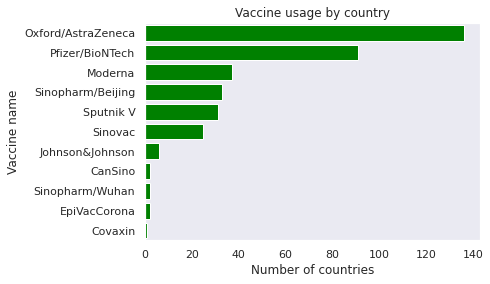

In [44]:
# number of countries using each vaccine
sns.set_theme(style= 'dark')
sns.set_palette('bright')
sns.countplot(data= vaccine_list, y='Vaccine_1', color = 'Green', saturation= 1.5, order = vaccine_list['Vaccine_1'].value_counts().index)
plt.xlabel('Number of countries')
plt.ylabel('Vaccine name')
plt.title('Vaccine usage by country')
plt.show()

The most popular vaccines (based on number of countries using them) are: Oxford/AstraZeneca, Pfizer/BioNTech and Moderna.

In [45]:
# review types of vaccines used by each continent (number of countries using)
vaccine_list.pivot_table(values='Country', index='Vaccine_1', columns= 'Continent', aggfunc='count')

Continent,Africa,Asia,Europe,North America,Oceania,South America
Vaccine_1,,,,,,
CanSino,NaN,1.0,NaN,1.0,NaN,NaN
Covaxin,NaN,1.0,NaN,NaN,NaN,NaN
EpiVacCorona,NaN,1.0,1.0,NaN,NaN,NaN
Johnson&Johnson,1.0,NaN,4.0,1.0,NaN,NaN
Moderna,1.0,3.0,28.0,5.0,NaN,NaN
Oxford/AstraZeneca,30.0,28.0,43.0,21.0,6.0,8.0
Pfizer/BioNTech,2.0,19.0,51.0,12.0,2.0,5.0
Sinopharm/Beijing,14.0,13.0,3.0,NaN,NaN,3.0
Sinopharm/Wuhan,NaN,2.0,NaN,NaN,NaN,NaN


Each continent has different preference towards vaccines:
- Oxford/AstraZeneca is used widely in all continents
- Moderna is mainly used in Europe and North America
- Pfizer/BioNTech is the most popular vaccine in Europe

In [46]:
# number of vaccines used by each country
vaccine_listcount = vaccine_list[['Country','Vaccine_1']].groupby(['Country']).count().reset_index()
vaccine_listcount.columns=['Country', 'Number_of_vaccines_used']
vaccine_listcount.head()

,Country,Number_of_vaccines_used
0,Afghanistan,1
1,Albania,2
2,Algeria,1
3,Andorra,2
4,Angola,1


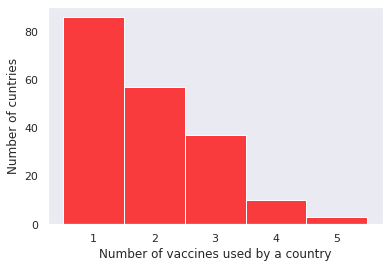

In [47]:
# visualize number of vaccines used by each country
sns.histplot(data= vaccine_listcount, x= 'Number_of_vaccines_used', color= 'Red', bins=5, binwidth= 1, discrete = True )
plt.xlabel('Number of vaccines used by a country')
plt.ylabel('Number of cuntries')
plt.show()

Most countries are using 1 to 3 different types of vacccines. Only a few cases use 4 or 5.

In [48]:
# Find countries that are most flexible with vaccine use (accept more than 3 types of vaccines)
vaccine_listcount[vaccine_listcount['Number_of_vaccines_used'] > 3 ]

,Country,Number_of_vaccines_used
14,Bahrain,4
23,Bosnia and Herzegovina,4
42,Czechia,4
75,Hungary,5
84,Italy,4
96,Lebanon,4
100,Lithuania,4
110,Mexico,5
139,Poland,4
143,Russia,4


In [49]:
# Find what type of vaccines some big countries are using
vaccine_listcount [vaccine_listcount ['Country'].isin(['United States', 'China', 'India', 'Canada'])]

,Country,Number_of_vaccines_used
30,Canada,3
34,China,3
77,India,2
185,United States,3


## 3. Current vaccination progress by country

In [50]:
# update kaggledata_latest to reflect changes we already made to kaggledata
kaggledata_latest = kaggledata.iloc[kaggledata.groupby('country')['total_vaccinations'].agg(pd.Series.idxmax)]
kaggledata_latest.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country name,Continent,Population
3,Afghanistan,AFG,2021-04-22,240000.0,240000.000000,0.0,0.0,8000.0,0.62,0.620000,0.00,206.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677.0
55,Albania,ALB,2021-04-23,391351.0,278353.925740,0.0,8353.0,10961.0,13.60,9.673192,0.00,3809.0,"Pfizer/BioNTech, Sinovac",Ministry of Health,https://twitter.com/gmanastirliu/status/138569...,"Albania, Republic of",Europe,2877581.0
57,Algeria,DZA,2021-02-19,75000.0,53344.809214,0.0,0.0,3748.0,0.17,0.120915,0.00,85.0,Sputnik V,Ministry of Health,https://www.echoroukonline.com/%d9%84%d9%82%d8...,"Algeria, People's Democratic Republic of",Africa,44117647.0
73,Andorra,AND,2021-04-19,26414.0,21733.000000,4681.0,0.0,1050.0,34.19,28.130000,6.06,13590.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Government of Andorra,https://www.govern.ad/covid19_newsletter/,"Andorra, Principality of",Europe,77257.0
80,Angola,AGO,2021-04-19,395447.0,395447.000000,0.0,0.0,18751.0,1.20,1.200000,0.00,571.0,Oxford/AstraZeneca,Ministry of Health,https://www.angop.ao/en/noticias/saude/covid-1...,"Angola, Republic of",Africa,32953917.0


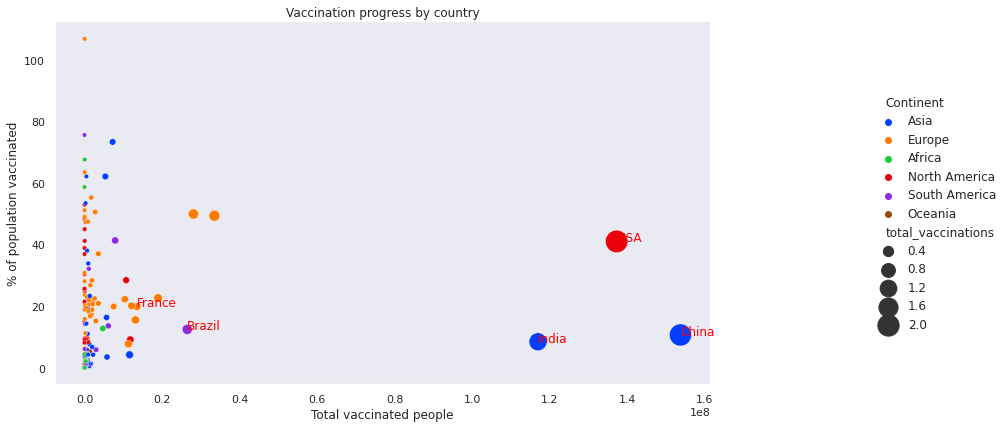

In [51]:
# review vaccination progress (total and %) by country
scatter= sns.relplot(kind= 'scatter',data= kaggledata_latest, y= 'people_vaccinated_per_hundred', x='people_vaccinated', hue = 'Continent', size= 'total_vaccinations' , sizes = (20,500), color = 'Green')
plt.xlabel('Total vaccinated people')
plt.ylabel('% of population vaccinated')
plt.title('Vaccination progress by country')
scatter.fig.set_figwidth(15)
scatter.fig.set_figheight(6)
plt.text(kaggledata_latest.people_vaccinated[kaggledata_latest.country=='United States'],kaggledata_latest.people_vaccinated_per_hundred[kaggledata_latest.country=='United States'],"USA", color='red')
plt.text(kaggledata_latest.people_vaccinated[kaggledata_latest.country=='China'],kaggledata_latest.people_vaccinated_per_hundred[kaggledata_latest.country=='China'],"China", color='red')
plt.text(kaggledata_latest.people_vaccinated[kaggledata_latest.country=='India'],kaggledata_latest.people_vaccinated_per_hundred[kaggledata_latest.country=='India'],"India", color='red')
plt.text(kaggledata_latest.people_vaccinated[kaggledata_latest.country=='Brazil'],kaggledata_latest.people_vaccinated_per_hundred[kaggledata_latest.country=='Brazil'],"Brazil", color='red')
plt.text(kaggledata_latest.people_vaccinated[kaggledata_latest.country=='France'],kaggledata_latest.people_vaccinated_per_hundred[kaggledata_latest.country=='France'],"France", color='red')
plt.show()

Majority of countries are having only <40% population vaccinated.

Countries with highest number of vaccinated population are China, USA and India 

In [52]:
# visualize vaccination rate by country 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
trace = go.Choropleth(
            locations = kaggledata_latest['country'],
            locationmode='country names',
            z = kaggledata_latest['people_vaccinated_per_hundred'],
            text = kaggledata_latest['country'],
            autocolorscale =False,
            reversescale = True,
            colorscale = 'viridis',
            marker = dict(
                line = dict(
                    color = 'rgb(0,0,0)',
                    width = 0.5)
            ),
            colorbar = dict(
                title = 'Percent vaccinated',
                tickprefix = '')
        )

data = [trace]
layout = go.Layout(
    title = '% of vaccinated population per country',
    geo = dict(
        showframe = True,
        showlakes = False,
        showcoastlines = True,
        projection = dict(
            type = 'natural earth'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot(fig)

In [53]:
# total nunber of vaccinated people by continent
pd.options.display.float_format = '{:.0f}'.format
kaggledata_latest.pivot_table(values='people_vaccinated', columns= 'Continent', aggfunc='sum')

Continent,Africa,Asia,Europe,North America,Oceania,South America
people_vaccinated,12196126,328807478,192665421,163044707,1561935,46889703


In [54]:
# average vaccinated rate by continent 
kaggledata_latest.pivot_table(values='people_vaccinated_per_hundred', columns= 'Continent', aggfunc='mean')

Continent,Africa,Asia,Europe,North America,Oceania,South America
people_vaccinated_per_hundred,4,12,24,20,2,16


- North American and the UK in general have higher vaccinated rate.
- Meanwhile penetration in African countries is still very low.
- EU countries (except for the UK): "unacceptably slow” progress (WHO) due to below reasons: 
  +	slow to negotiate a contract with vaccine manufacturers
  +	regulators were also slow to approve the shots and led to a simmering tussle with AstraZeneca as the pharmaceutical giant repeatedly slashed its delivery commitments
  +	several countries briefly halted their use of the Oxford-AstraZeneca vaccine amid safety concerns-> public confidence and further slower progress


## 4. Vaccination progress by country over time

In [55]:
# create function for time series visualization
def plot_time_variation_countries_group(data_df, feature, title, countries):
    data = []
    for country in countries:
        df = data_df.loc[data_df.country==country]
        trace = go.Scatter(
            x = df['date'],y = df[feature],
            name=country,
            mode = "markers+lines",
            marker_line_width = 1,
            marker_size = 8,
            marker_symbol = 'circle',
            text=df['country'])
        data.append(trace)
    layout = dict(title = title,
          xaxis = dict(title = 'Date', showticklabels=True,zeroline=True, zerolinewidth=1, zerolinecolor='grey',
                       showline=True, linewidth=2, linecolor='black', mirror=True,
                       tickfont=dict(size=10,color='darkblue'),), 
          yaxis = dict(title = feature, gridcolor='lightgrey', zeroline=True, zerolinewidth=1, zerolinecolor='grey',
                       showline=True, linewidth=2, linecolor='black', mirror=True),
                       plot_bgcolor = 'rgba(0, 0, 0, 0)', paper_bgcolor = 'rgba(0, 0, 0, 0)',
         hovermode = 'x', 
         height=800
         )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='all_countries')

In [56]:
# select a list of countries with highest number of COVID-19 cases as of now for review
countries = ['Brazil', 'India', 'France', 'Russia', 'United Kingdom', 'Turkey', 'Italy', 'Spain', 'Germany', 'United States', 'China', 'Canada', 'Poland', 'Colombia', 'Argentina']
# extract df for selected countries
kaggledata_selected = kaggledata[kaggledata['country'].isin (countries)]

In [57]:
# Total vaccinated population by country over time 
plot_time_variation_countries_group(kaggledata_selected, 'people_vaccinated', 'Total vaccinated population evolution (selected countries)', countries)

Most countries started vaccination in Dec 2020- Jan 2021, and total number of vaccinated poeple have increased sharply over time.

In [58]:
# % vaccinated population by country over time 
plot_time_variation_countries_group(kaggledata_selected, 'people_vaccinated_per_hundred', '% vaccinated population evolution (selected countries)', countries)

UK is the country with best acceleration and current highest % vaccinated. US is in second place

In [59]:
# daily vaccination by country over time 
plot_time_variation_countries_group(kaggledata_selected, 'daily_vaccinations', 'Daily vaccination evolution (selected countries)', countries)

Daily vaccinations have fluctuated significantly in the last 3 months:
- US: on an increasing trend (which can be due to improved operation and capacity)
- China: sharp increase from mid Mar, start declining in Apr
- India: low daily rate in Jan-Feb but started increasing in Mar-Apr. second highest daily vaccination as of now

# Machine Learning

In [60]:
kaggledata.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country name,Continent,Population
0,Afghanistan,AFG,2021-02-28,8200,8200,0,0,1367,0,0,0,35,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,41000000
1,Afghanistan,AFG,2021-03-16,54000,54000,0,0,2862,0,0,0,74,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38571429
2,Afghanistan,AFG,2021-04-07,120000,120000,0,0,3000,0,0,0,77,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677
3,Afghanistan,AFG,2021-04-22,240000,240000,0,0,8000,1,1,0,206,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,"Afghanistan, Islamic Republic of",Asia,38709677
4,Albania,ALB,2021-01-12,128,128,0,0,64,0,0,0,22,"Pfizer/BioNTech, Sinovac",Ministry of Health,https://twitter.com/gmanastirliu/status/138569...,"Albania, Republic of",Europe,inf


Filter data for United States

In [61]:
kaggledata_reg = kaggledata[kaggledata['country'] == 'United States']
kaggledata_reg['date']=pd.to_datetime(kaggledata_reg['date'])
dt=kaggledata_reg.groupby('date').sum()

In [62]:
dt.tail()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Population
date,,,,,,,,,,
2021-04-19,211581309,132321628,85365180,2174495,3127038,63,40,26,9350,334463024
2021-04-20,213388238,133266995,86223506,1806929,3015065,64,40,26,9015,334464323
2021-04-21,215951909,134445595,87592646,2563671,3022868,65,40,26,9039,334446196
2021-04-22,218947643,135791031,89245776,2995734,2947229,65,41,27,8812,334424382
2021-04-23,222322230,137234889,91175995,3374587,2862758,66,41,27,8560,334419720


Visualize the trend of total vaccination per hundred vs people vaccinated per hundred

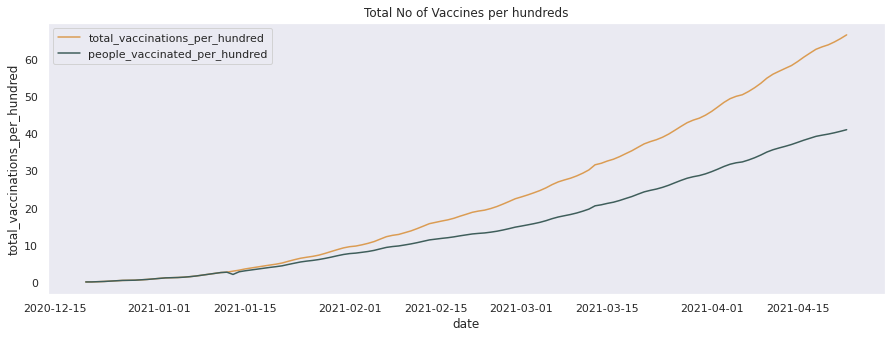

In [63]:
#lets visualize our total vaccination by per 100
fig,ax=plt.subplots(figsize=(15,5))
plt.title('Total No of Vaccines per hundreds')
sns.lineplot(x=dt.index,y=dt['total_vaccinations_per_hundred'],color='#db9c53',label='total_vaccinations_per_hundred')
sns.lineplot(x=dt.index,y=dt['people_vaccinated_per_hundred'],color='#3f5e5b',label='people_vaccinated_per_hundred')

Add one more column that is difference of date

In [64]:
dt['date_diff']=dt['people_fully_vaccinated']
count=0
for index, row in dt.iterrows():
    row['date_diff']=count
    count+=1
dt.head()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Population,date_diff
date,,,,,,,,,,,
2020-12-20,556208,556208,0,0,0,0,0,0,0,327181176,0
2020-12-21,614117,614117,0,57909,57909,0,0,0,173,341176111,1
2020-12-23,1008025,1008025,0,0,150606,0,0,0,450,336008333,2
2020-12-26,1944585,1944585,0,0,231396,1,1,0,692,335273276,3
2020-12-28,2127143,2127143,0,0,216147,1,1,0,646,332366094,4


##Linear Regression Model

In [65]:
#creating model
from sklearn.linear_model import LinearRegression
model=LinearRegression()

In [66]:
x=dt[['date_diff']]
y=dt['people_fully_vaccinated']
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
print(model.coef_)
print(model.intercept_)

[828022.89456827]
-15404099.543597188


In [68]:
pr=model.predict(x)

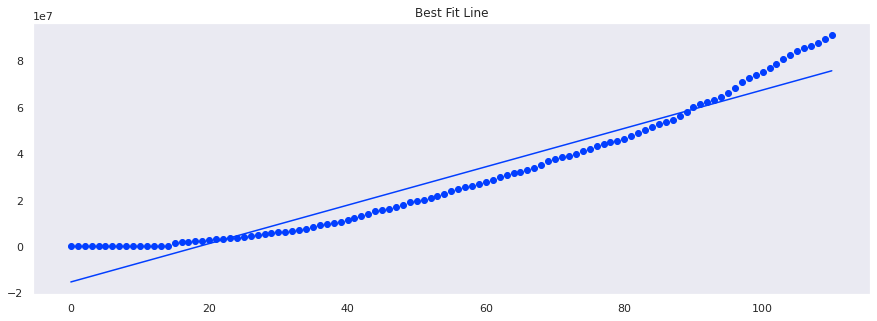

In [69]:
#lets visualize our total vaccination by day
fig,ax=plt.subplots(figsize=(15,5))
plt.title('Best Fit Line')
plt.scatter(x=dt['date_diff'],y=dt['people_fully_vaccinated'])
plt.plot(x,pr)

In [70]:
# lets predict for after 425 days
print(int(model.predict([[425]])))

336505630


Estimate the number of days required to achieve the collective immunity threshold

In [71]:
#y = a*x + b
y = 0.7 * 330000000
a = model.coef_
b = model.intercept_
x = (y - b)/a
print("United States will achieve 70% threshold in " + str(round(x[0])) + " days from the 1st day of vaccination")

United States will achieve 70% threshold in 298 days from the 1st day of vaccination


## Time Series - SARIMA Model

In [72]:
kaggledata_ts = pd.read_csv('/content/gdrive/Shareddrives/IS833 Covid vaccination prediction/covid_vaccination_data/country_vaccinations.csv')
kaggledata_ts.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0,0,nan,nan,nan,0,0,nan,nan,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,nan,nan,nan,nan,1367,nan,nan,nan,35,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,nan,nan,nan,nan,1367,nan,nan,nan,35,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


Filter for the United States data

In [73]:
kaggledata_ts = kaggledata_ts[kaggledata_ts['country'] == 'United States']
kaggledata_ts.tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
13231,United States,USA,2021-04-19,211581309,132321628,85365180,2174495,3127038,63,40,26,9350,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Centers for Disease Control and Prevention,https://covid.cdc.gov/covid-data-tracker/#vacc...
13232,United States,USA,2021-04-20,213388238,133266995,86223506,1806929,3015065,64,40,26,9015,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Centers for Disease Control and Prevention,https://covid.cdc.gov/covid-data-tracker/#vacc...
13233,United States,USA,2021-04-21,215951909,134445595,87592646,2563671,3022868,65,40,26,9039,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Centers for Disease Control and Prevention,https://covid.cdc.gov/covid-data-tracker/#vacc...
13234,United States,USA,2021-04-22,218947643,135791031,89245776,2995734,2947229,65,41,27,8812,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Centers for Disease Control and Prevention,https://covid.cdc.gov/covid-data-tracker/#vacc...
13235,United States,USA,2021-04-23,222322230,137234889,91175995,3374587,2862758,66,41,27,8560,"Johnson&Johnson, Moderna, Pfizer/BioNTech",Centers for Disease Control and Prevention,https://covid.cdc.gov/covid-data-tracker/#vacc...


Fill the null values with next non zero value

In [74]:
kaggledata_ts = kaggledata_ts[['date','people_fully_vaccinated']]
kaggledata_ts.fillna(method='bfill', inplace=True)
kaggledata_ts.head(10)

,date,people_fully_vaccinated
13111,2020-12-20,1342086
13112,2020-12-21,1342086
13113,2020-12-22,1342086
13114,2020-12-23,1342086
13115,2020-12-24,1342086
13116,2020-12-25,1342086
13117,2020-12-26,1342086
13118,2020-12-27,1342086
13119,2020-12-28,1342086
13120,2020-12-29,1342086


In [75]:
kaggledata_ts.isna().sum()

date                       0
people_fully_vaccinated    0
dtype: int64

In [76]:
kaggledata_ts['date']=pd.to_datetime(kaggledata_ts['date'])
kaggledata_ts=kaggledata_ts.groupby('date').sum()

In [77]:
kaggledata_ts.head()

,people_fully_vaccinated
date,
2020-12-20,1342086
2020-12-21,1342086
2020-12-22,1342086
2020-12-23,1342086
2020-12-24,1342086


Trend of people fully vaccinated

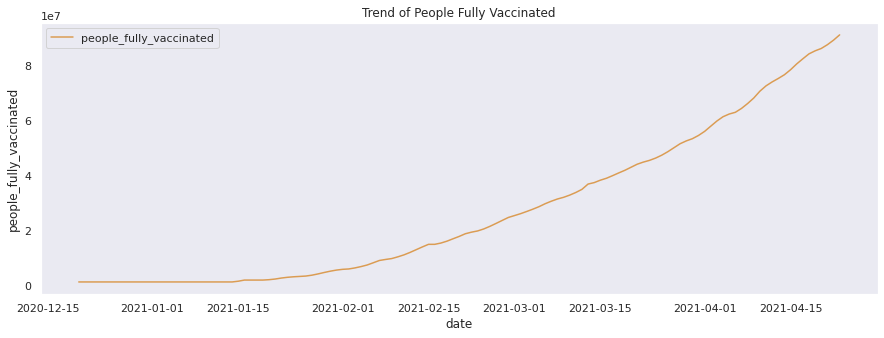

In [78]:
fig,ax=plt.subplots(figsize=(15,5))
plt.title('Trend of People Fully Vaccinated')
sns.lineplot(x=kaggledata_ts.index,y=kaggledata_ts['people_fully_vaccinated'],color='#db9c53',label='people_fully_vaccinated')

In [79]:
kaggledata_ts['people_fully_vaccinated'] = kaggledata_ts['people_fully_vaccinated'].astype(int)
kaggledata_ts.head()

,people_fully_vaccinated
date,
2020-12-20,1342086
2020-12-21,1342086
2020-12-22,1342086
2020-12-23,1342086
2020-12-24,1342086


<Figure size 432x288 with 0 Axes>

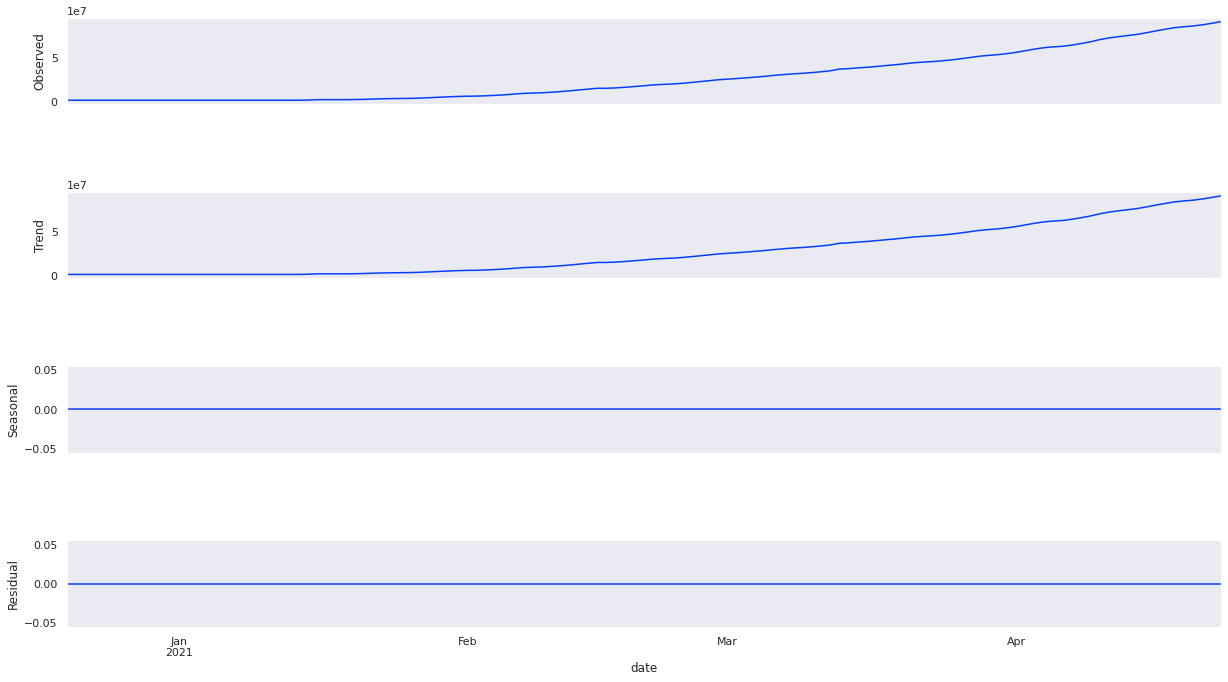

In [80]:
#Decomposing data to observe if there exists a sesional trend

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(kaggledata_ts['people_fully_vaccinated'], model='additive', freq=1)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

Apply Dickey-Fuller test to check whether the series is stationary

In [81]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function finds mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The smaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

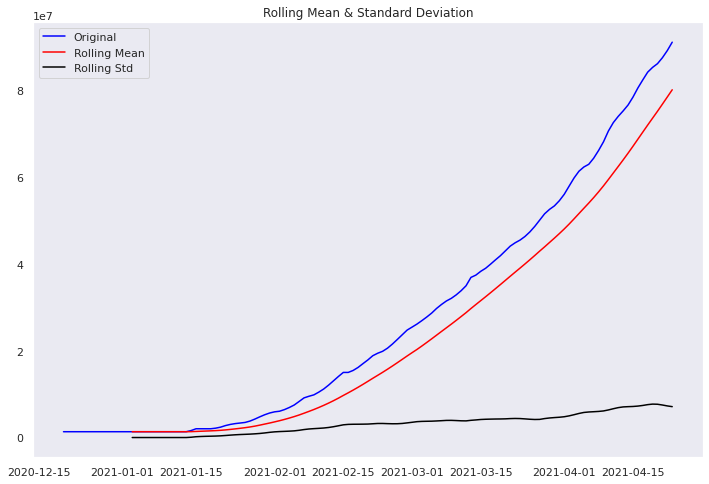

Results of Dickey-Fuller Test:
p-value = 0.9813. The series is likely non-stationary.
Test Statistic                  0
p-value                         1
#Lags Used                      9
Number of Observations Used   115
Critical Value (1%)            -3
Critical Value (5%)            -3
Critical Value (10%)           -3
dtype: float64


In [82]:
test_stationarity(kaggledata_ts['people_fully_vaccinated'])

### Data Transformation to Achieve Stationarity - Differencing

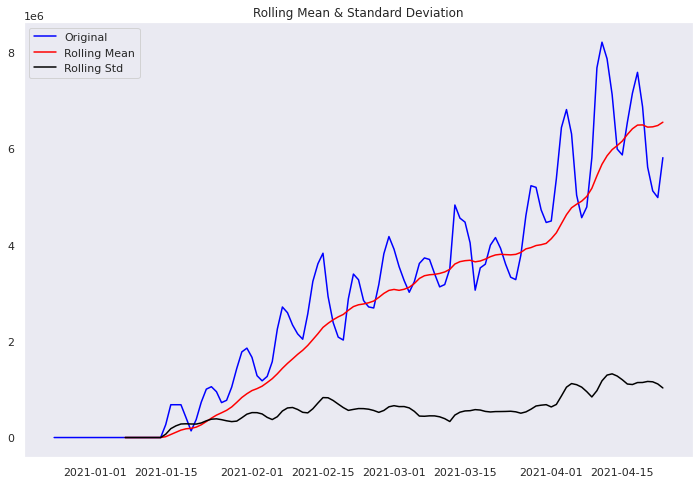

Results of Dickey-Fuller Test:
p-value = 0.9368. The series is likely non-stationary.
Test Statistic                 -0
p-value                         1
#Lags Used                     13
Number of Observations Used   107
Critical Value (1%)            -3
Critical Value (5%)            -3
Critical Value (10%)           -3
dtype: float64


In [83]:
#There are various methods for making series stationary like log, differencing and so on..
#Here we are using differencing , shift operator shifts the 'people_fully_vaccinated' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.7291 which is quite good as compared to our previous value 0.9966
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = kaggledata_ts.people_fully_vaccinated - kaggledata_ts.people_fully_vaccinated.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 15)

Plot autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)


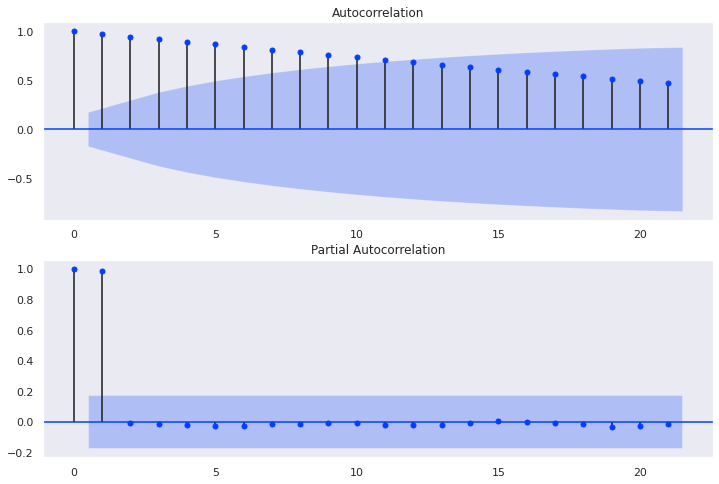

In [84]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(kaggledata_ts.people_fully_vaccinated, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(kaggledata_ts.people_fully_vaccinated, ax=ax2) # using default value of lag

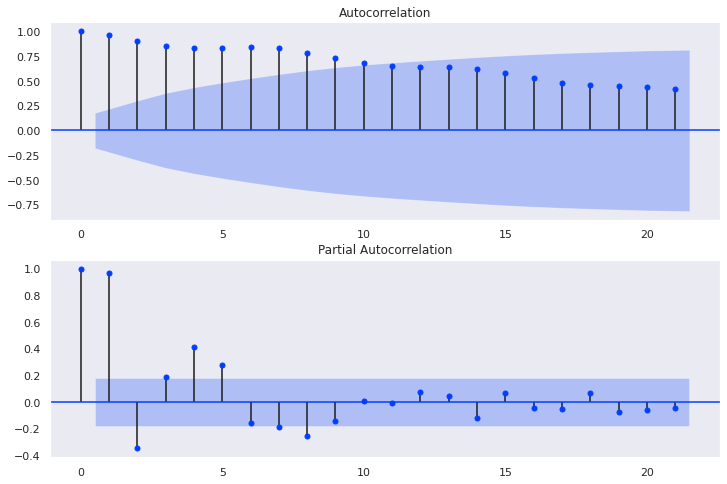

In [85]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)

In [86]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).

sarimax_mod = sm.tsa.statespace.SARIMAX(kaggledata_ts.people_fully_vaccinated, trend='n', order=(14,1,0)).fit()
print(sarimax_mod.summary())

                              Statespace Model Results                             
Dep. Variable:     people_fully_vaccinated   No. Observations:                  125
Model:                   SARIMAX(14, 1, 0)   Log Likelihood               -1708.043
Date:                     Tue, 27 Apr 2021   AIC                           3446.086
Time:                             15:38:10   BIC                           3488.390
Sample:                         12-20-2020   HQIC                          3463.271
                              - 04-23-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4375      0.064      6.874      0.000       0.313       0.562
ar.L2          0.1328      0.121      1.097      0.273      -0.105       0.370
ar.L3       

NormaltestResult(statistic=31.0993556822723, pvalue=1.7654715287805926e-07)


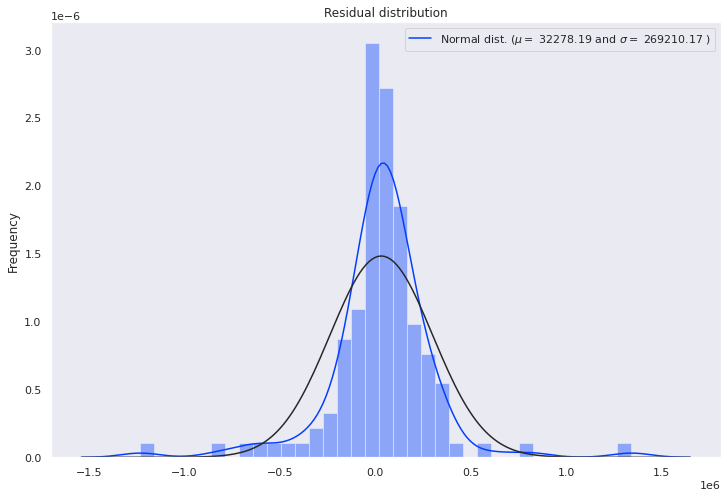

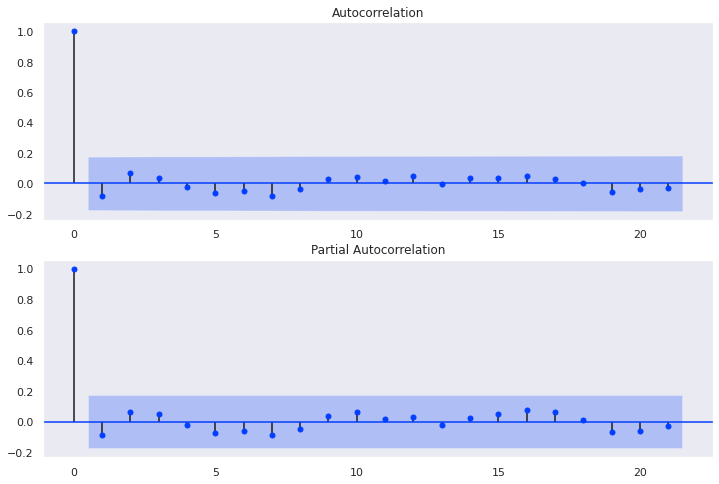

In [87]:
import scipy.stats as stats
from scipy.stats import normaltest

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

In [88]:
kaggledata_ts.head()

,people_fully_vaccinated
date,
2020-12-20,1342086
2020-12-21,1342086
2020-12-22,1342086
2020-12-23,1342086
2020-12-24,1342086


###Forecast fully vaccinated population for Covid-19 in the US using our model

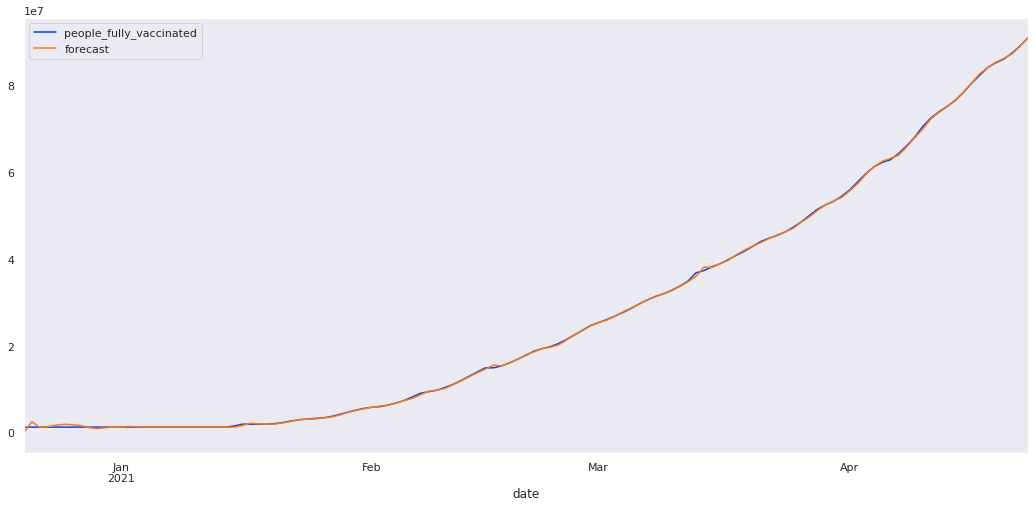

In [89]:
from datetime import timedelta
today = datetime.date.today() - timedelta(days=1)

start_index = '20-DEC-20'
end_index = today.strftime("%Y-%m-%d")

kaggledata_arima = kaggledata_ts

#adding forecasted values and plotting
kaggledata_ts['forecast'] = sarimax_mod.predict(start= start_index, end = end_index, dynamic= False)  

kaggledata_ts[start_index:][['people_fully_vaccinated', 'forecast']].plot(figsize=(18, 8))

Forecast from today to the end of this year

In [90]:
#lets forecast for upcomming dates
#Please use the last available date in the dataset for the 'start'
future_predict = sarimax_mod.predict(start = '24-APR-21', end = '31-DEC-21', dynamic= True)
future_predict

2021-04-24    93050790
2021-04-25    94568135
2021-04-26    95719710
2021-04-27    96696703
2021-04-28    97924476
                ...   
2021-12-27   294182385
2021-12-28   294556409
2021-12-29   294943004
2021-12-30   295338197
2021-12-31   295730126
Freq: D, Length: 252, dtype: float64

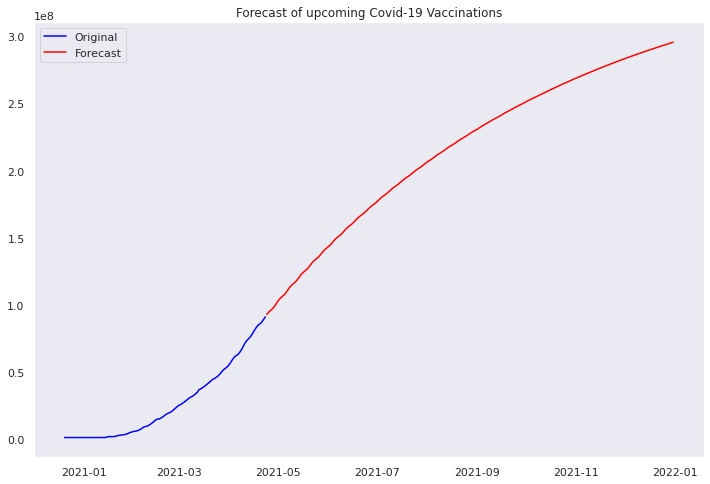

In [91]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(kaggledata_ts['people_fully_vaccinated'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcoming Covid-19 Vaccinations')
plt.show()

Create a dataframe and send the forecasted results to this new dataframe

In [92]:
immunity_threshold = pd.DataFrame()
immunity_threshold['date'] = future_predict.index
immunity_threshold['people_fully_vaccinated'] = future_predict.values
immunity_threshold.head()

,date,people_fully_vaccinated
0,2021-04-24,93050790
1,2021-04-25,94568135
2,2021-04-26,95719710
3,2021-04-27,96696703
4,2021-04-28,97924476


United States will achieve the collective immunity threshold or 70% of the people are vaccinated by Sep 2nd, 2021

In [93]:
immunity_threshold[(immunity_threshold['people_fully_vaccinated'] > 0.7 * 330000000)].head(1)

,date,people_fully_vaccinated
131,2021-09-02,231771419


Notice that there is a slight gap in the plot above because of one missing date. So, in the next few steps we address the missing date

In [94]:
immunity_threshold.loc[-1] = [kaggledata_ts.index[-1],kaggledata_ts['people_fully_vaccinated'][-1]]

In [95]:
immunity_threshold

,date,people_fully_vaccinated
0,2021-04-24,93050790
1,2021-04-25,94568135
2,2021-04-26,95719710
3,2021-04-27,96696703
4,2021-04-28,97924476
...,...,...
248,2021-12-28,294556409
249,2021-12-29,294943004
250,2021-12-30,295338197
251,2021-12-31,295730126


In [96]:
immunity_threshold.index = immunity_threshold.index + 1

In [97]:
immunity_threshold

,date,people_fully_vaccinated
1,2021-04-24,93050790
2,2021-04-25,94568135
3,2021-04-26,95719710
4,2021-04-27,96696703
5,2021-04-28,97924476
...,...,...
249,2021-12-28,294556409
250,2021-12-29,294943004
251,2021-12-30,295338197
252,2021-12-31,295730126


We have now taken care of the missing date and its corresponding value. We sort the index next.

In [98]:
immunity_threshold = immunity_threshold.sort_index()
immunity_threshold

,date,people_fully_vaccinated
0,2021-04-23,91175995
1,2021-04-24,93050790
2,2021-04-25,94568135
3,2021-04-26,95719710
4,2021-04-27,96696703
...,...,...
248,2021-12-27,294182385
249,2021-12-28,294556409
250,2021-12-29,294943004
251,2021-12-30,295338197


Set the date as index

In [99]:
immunity_threshold['date'] = pd.to_datetime(immunity_threshold['date'], format="%d-%b-%y")
immunity_threshold = immunity_threshold.set_index('date')

Plot the new graph. We see that the gap due to the missing date has been filled.

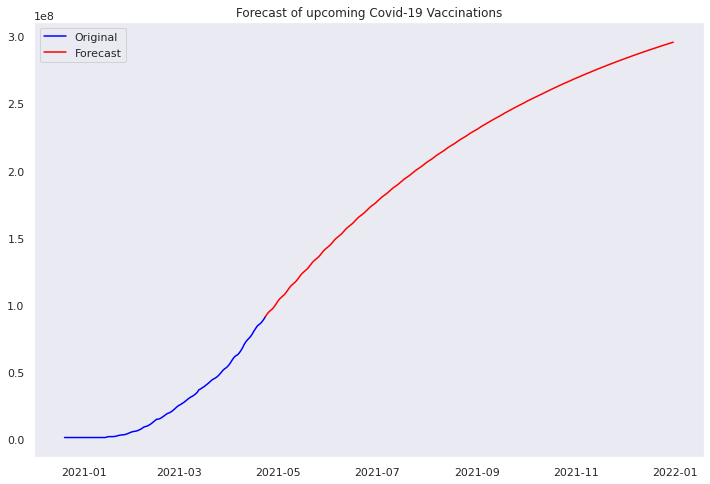

In [100]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(kaggledata_ts['people_fully_vaccinated'], color='blue',label='Original')
fore = plt.plot(immunity_threshold['people_fully_vaccinated'], color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcoming Covid-19 Vaccinations')
plt.show()

### Forecast with Confidence Interval

In [101]:
fcast = sarimax_mod.get_forecast('31-DEC-21')
fcast = fcast.conf_int()
fcast

,lower people_fully_vaccinated,upper people_fully_vaccinated
2021-04-24,92662817,93438764
2021-04-25,93888758,95247511
2021-04-26,94756019,96683400
2021-04-27,95458147,97935259
2021-04-28,96429510,99419442
...,...,...
2021-12-27,92970921,495393849
2021-12-28,92460042,496652775
2021-12-29,91962548,497923460
2021-12-30,91474187,499202207


In [102]:
fcast = fcast.reset_index()
fcast.loc[-1] = [kaggledata_ts.index[-1],kaggledata_ts['people_fully_vaccinated'][-1],kaggledata_ts['people_fully_vaccinated'][-1]]
fcast.index = fcast.index + 1
fcast = fcast.sort_index()
fcast['index'] = pd.to_datetime(fcast['index'], format="%d-%b-%y")
fcast = fcast.set_index('index')
fcast

,lower people_fully_vaccinated,upper people_fully_vaccinated
index,,
2021-04-23,91175995,91175995
2021-04-24,92662817,93438764
2021-04-25,93888758,95247511
2021-04-26,94756019,96683400
2021-04-27,95458147,97935259
...,...,...
2021-12-27,92970921,495393849
2021-12-28,92460042,496652775
2021-12-29,91962548,497923460


Plot the vaccination forecast with confidence interval

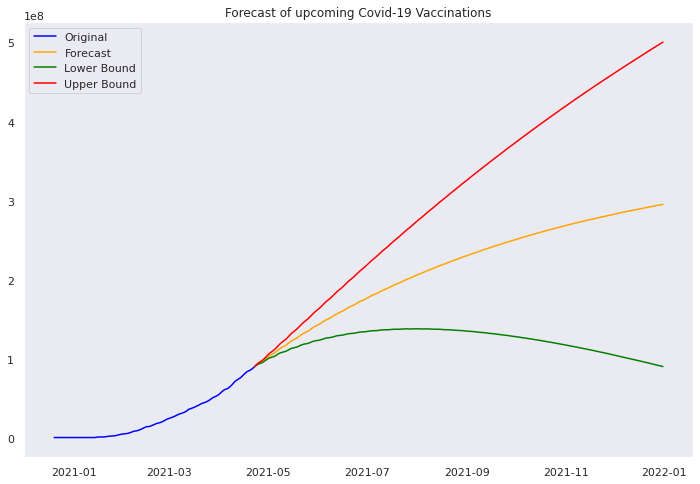

In [103]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(kaggledata_ts['people_fully_vaccinated'], color='blue',label='Original')
fore = plt.plot(immunity_threshold['people_fully_vaccinated'], color='orange', label='Forecast')
lower = plt.plot(fcast['lower people_fully_vaccinated'], color='green', label='Lower Bound')
upper = plt.plot(fcast['upper people_fully_vaccinated'], color='red', label='Upper Bound')
plt.legend(loc='best')
plt.title('Forecast of upcoming Covid-19 Vaccinations')
plt.show()

# Conclusion



*   From our Linear Regression model, we found that United States will achieve collective immunity threshold by around Sep 20th, 2021
*   From our SARIMA Time Series model, we found that United States will achieve the collective immunity threshold by around Sep 2nd, 2021

The prediction and forecasts from both the models appear to be reasonable and can change with variations in the on ground conditions. We were also able to forecast the upper and lower vaccination thresholds using our SARIMA model to take care of any changes in the underlying conditions.

Learnings:


*   We learnt the importance of cleaning and feature engineering before applying our models
*   During the EDA phase, we also learnt to build visualizations by using custom functions


*   We applied the general linear regression that was taught in class to achieve a baseline result
*   Although it was not easy, we extrapolated our class learnings to build a Seasonal ARIMA model and forecast the covid vaccinations using real time data that's updated on a day to day basis

The models we have built can also be used to forecast the collective immunity thresholds and vaccination trends for countries other than the United States also.





